# 🌳 RAPTOR RAG: Recursive Abstractive Processing for Tree-Organized Retrieval 🌲

Welcome to the RAPTOR RAG project! This repository contains a from-scratch implementation of the RAPTOR (Recursive Abstractive Processing for Tree-Organized Retrieval) approach, inspired by the research paper [RAPTOR: RECURSIVE ABSTRACTIVE PROCESSING FOR TREE-ORGANIZED RETRIEVAL](https://arxiv.org/pdf/2401.18059v1) .

---

## 📚 Overview

RAPTOR is a novel retrieval-augmented generation (RAG) framework that organizes document chunks into a hierarchical tree using recursive clustering and abstractive summarization. This structure enables efficient and context-rich retrieval for downstream question answering and information retrieval tasks.

---

## 🚀 Features

- **Recursive Tree Construction:** Documents are recursively clustered (using Gaussian Mixture Models) and summarized to build a multi-level tree.
- **Abstractive Summarization:** Each cluster is summarized using an LLM, capturing the essence of grouped texts.
- **Flexible Querying:** Supports both:
    - **Tree Traversal Method:** Traverses the tree top-down, selecting relevant nodes at each level.
    - **Tree Collapse Method:** Collapses the tree into a flat set and retrieves the most relevant nodes up to a token limit.
- **Visualization:** Includes GMM clustering visualization for synthetic embeddings.
- **Modular & Extensible:** Easily swap out embedding models, LLMs, and clustering strategies.

---

## 🛠️ How It Works

1. **Document Loading:** Documents are loaded and split into manageable chunks.(also used semantic chunking)
2. **Embedding & Clustering:** Chunks are embedded and clustered recursively using GMM.
3. **Summarization:** Each cluster is summarized via an LLM, forming parent nodes in the tree.
4. **Tree Construction:** The process repeats until the tree root is reached.
5. **Querying:** Retrieve relevant context using either tree traversal or tree collapse methods.
6. **Answer Generation:** The retrieved context is used to generate answers to user queries.

---

## 📊 Example: GMM Clustering Visualization

The notebook includes a demonstration of GMM clustering on synthetic 5D embeddings, visualized in 2D using PCA, to illustrate the clustering process used in RAPTOR.

---

## 📦 Usage

- Clone the repository and install the required dependencies.
- Follow the notebook cells to load your data, build the RAPTOR tree, and perform queries.
- Switch between tree traversal and tree collapse querying as needed.

---

## 📄 Reference

This implementation is inspired by:

> RAPTOR: RECURSIVE ABSTRACTIVE PROCESSING FOR TREE-ORGANIZED RETRIEVAL. [arXiv:2401.18059v1](https://arxiv.org/pdf/2401.18059v1)

---

## CITATION
 ```bibtex
 @inproceedings{sarthi2024raptor,
    title={RAPTOR: Recursive Abstractive Processing for Tree-Organized Retrieval},
    author={Sarthi, Parth and Abdullah, Salman and Tuli, Aditi and Khanna, Shubh and Goldie, Anna and Manning, Christopher D.},
    booktitle={International Conference on Learning Representations (ICLR)},
    year={2024}
}
```
---
## 💡 Acknowledgements

- Thanks to the RAPTOR authors for their innovative work!
- Built with 🤗 [LlamaIndex](https://github.com/jerryjliu/llama_index), [LangChain](https://github.com/langchain-ai/langchain), and [scikit-learn](https://scikit-learn.org/).

---

## 📝 Explore the Code

Check out the notebook cells below for detailed implementation, usage examples, and visualizations!

---

Happy experimenting! 🚀

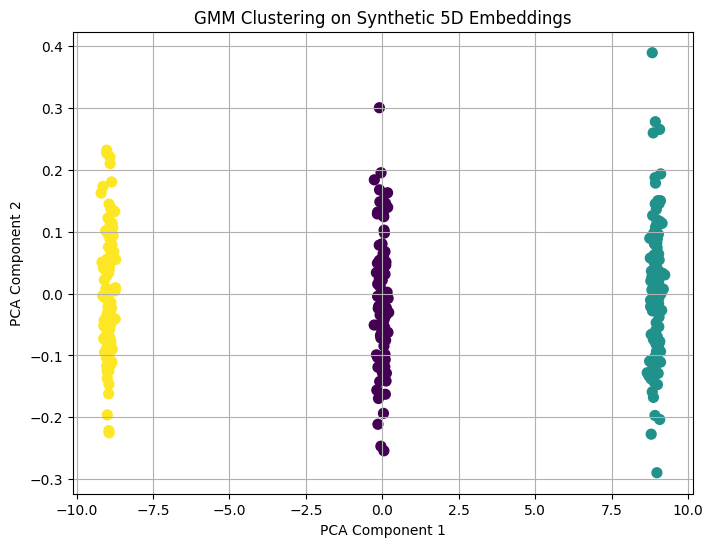

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#  Generate synthetic 5D embeddings clustered around 3 centers
np.random.seed(42)

# Cluster 1: around [1, 1, 1, 1, 1]
cluster_1 = np.random.normal(loc=1.0, scale=0.1, size=(100, 5))

# Cluster 2: around [5, 5, 5, 5, 5]
cluster_2 = np.random.normal(loc=5.0, scale=0.1, size=(100, 5))

# Cluster 3: around [9, 9, 9, 9, 9]
cluster_3 = np.random.normal(loc=9.0, scale=0.1, size=(100, 5))

# Combine into one dataset
X = np.vstack([cluster_1, cluster_2, cluster_3])

#  Apply GMM clustering
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X)
labels = gmm.predict(X)
# print(labels)
#  Reduce to 2D using PCA for visualization
from sklearn.decomposition import PCA

X_2d = PCA(n_components=2).fit_transform(X)

# Step 4: Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis', s=50)
plt.title("GMM Clustering on Synthetic 5D Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

In [ ]:
# !pip install llama_index.llms.langchain
# !pip install langchain_community
# %pip install llama-index-embeddings-google-genai
# !pip install llama_index
# %pip install -U langchain-google-genai
# %pip install -qU langchain-groq
# !pip install llama-index-readers-file

In [ ]:
import getpass
import os
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

Enter your Google AI API key: ··········


In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [ ]:
from llama_index.core import VectorStoreIndex, Settings, SimpleDirectoryReader
from llama_index.core.node_parser import SentenceSplitter
from llama_index.embeddings.google_genai import GoogleGenAIEmbedding
documents = SimpleDirectoryReader("data").load_data()
splitter = SentenceSplitter(chunk_size=1000,chunk_overlap=200)
nodes = splitter.get_nodes_from_documents(documents)
Settings.llm = llm
vector_index = VectorStoreIndex(nodes)
retriever = vector_index.as_retriever(similarity_top_k=5)

In [6]:
texts=[node.text for node in nodes]

Image Reference : [RAPTOR Paper](https://arxiv.org/pdf/2401.18059v1)
![Tree](https://raw.githubusercontent.com/prasanna00019/RAG-Playground/main/RAPTOR_RAG/tree_construction.png)

In [ ]:
from sklearn.mixture import GaussianMixture
from llama_index.core import Settings

def construct_RAPTOR_tree(texts):
    level_dict = {}
    level_dict[0] = texts
    current_level = 0
    parent_child_dict = {}
    while len(level_dict[current_level]) > 1:
        current_texts = level_dict[current_level]
        if len(current_texts) <= 2:
            print("*** Reached base case (<= 2 texts). Stopping tree construction. ***")
            break
        print(f"--- Processing Level {current_level} with {len(current_texts)} texts ---")
        embeddings = Settings.embed_model.get_text_embedding_batch(current_texts, show_progress=True)
        num_clusters = max(2, int(len(current_texts) / 5))
        gmm = GaussianMixture(n_components=num_clusters, random_state=42)
        labels = gmm.fit_predict(embeddings)
        texts_in_current_cluster = [""] * num_clusters
        for k in range(num_clusters):
            for i, j in zip(labels, current_texts):
                if i == k:
                    texts_in_current_cluster[i] += j + " "
        # Summarization Loop
        next_level_texts = []
        for k in range(num_clusters):
            combined_text_for_one_cluster = texts_in_current_cluster[k].strip()
            if not combined_text_for_one_cluster:
                continue
            prompt = f"Summarize the following texts into a single, cohesive paragraph:\n\n{combined_text_for_one_cluster}"
            summary = Settings.llm.complete(prompt).text
            original_texts_for_cluster = [text for i, text in enumerate(current_texts) if labels[i] == k]
            parent_child_dict[summary] = original_texts_for_cluster
            next_level_texts.append(summary)
            print(f"  > Generated summary for cluster {k}")
        current_level += 1
        level_dict[current_level] = next_level_texts
    return level_dict , parent_child_dict

In [10]:
raptor_tree,parent_child_dict=construct_RAPTOR_tree(texts)

--- Processing Level 0 with 10 texts ---


Generating embeddings:   0%|          | 0/10 [00:00<?, ?it/s]

  > Generated summary for cluster 0
  > Generated summary for cluster 1
*** Reached base case (<= 2 texts). Stopping tree construction. ***


Image Reference : [RAPTOR Paper](https://arxiv.org/pdf/2401.18059v1)
![Tree](https://raw.githubusercontent.com/prasanna00019/RAG-Playground/main/RAPTOR_RAG/traversal.png)

In [ ]:
import numpy as np
from llama_index.core import Settings
from sklearn.metrics.pairwise import cosine_similarity

def query_tree_traversal(query, tree, parent_to_child_dict, k= 1, d = 3):
    """
    Traverses the RAPTOR tree to find relevant context for a given query.

    Args:
        query (str): The user's query.
        tree (dict): The RAPTOR tree, structured as a dictionary of levels to node texts.
        parent_to_child_dict (dict): A mapping from parent node text to a list of its child node texts.
        k (int): The number of top nodes to select at each level of traversal.
        d (int): The depth of the traversal.

    Returns:
        list[str]: A list of relevant text nodes concatenated from the traversal.
    """
    #  Embed the query
    query_embedding = Settings.embed_model.get_text_embedding(query)
    query_embedding_np = np.array(query_embedding).reshape(1, -1)
    #  Start at the root layer of the tree
    # The root layer is the one with the highest level number (most summarized)
    root_level = max(tree.keys())
    nodes_to_check = tree[root_level]
    # This list will store the top-k nodes from all traversed levels (S1, S2, ..., Sd)
    all_relevant_nodes = []
    #  Recursively traverse for 'd' layers
    for depth in range(d):
        # Break the loop if there are no more nodes to explore (e.g., reached leaf nodes)
        if not nodes_to_check:
            print(f"--- Traversal stopped at depth {depth}: No more child nodes to explore. ---")
            break
        print(f"--- Processing Depth {depth + 1} with {len(nodes_to_check)} candidate nodes ---")
        # Embed the current nodes
        node_embeddings = Settings.embed_model.get_text_embedding_batch(nodes_to_check, show_progress=True)
        node_embeddings_np = np.array(node_embeddings)
        # Compute cosine similarity between the query and all nodes at the current level
        similarities = cosine_similarity(query_embedding_np, node_embeddings_np)[0]
        #  Select the top-k nodes based on similarity
        # We use argsort to get indices of similarities in ascending order, then take the last 'k'
        top_k_indices = np.argsort(similarities)[-k:]
        # Reverse the indices to get the highest similarity first
        top_k_nodes = [nodes_to_check[i] for i in reversed(top_k_indices)]
        print(f"  > Selected {len(top_k_nodes)} top nodes at this depth.")
        #  Add the selected nodes to our final context set
        all_relevant_nodes.extend(top_k_nodes)
        # print("at this level ",all_relevant_nodes)
        # Prepare for the next level: get the children of the selected top-k nodes
        next_nodes_to_check = []
        for node in top_k_nodes:
            # Check if this node is a parent and has children
            if node in parent_to_child_dict:
                children = parent_to_child_dict[node]
                next_nodes_to_check.extend(children)
        # Update the list of nodes for the next iteration, removing duplicates
        nodes_to_check = list(set(next_nodes_to_check))
    #  Concatenate and return the final relevant context
    final_context = list(dict.fromkeys(all_relevant_nodes))
    return final_context

In [30]:
a2=query_tree_traversal("what is supervised learning ?",raptor_tree,parent_child_dict,1,2)
print(a2)

--- Processing Depth 1 with 2 candidate nodes ---


Generating embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 2 with 6 candidate nodes ---


Generating embeddings:   0%|          | 0/6 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
['Machine Learning (ML) is a field primarily used for prediction, classification, and clustering, encompassing four main types: Supervised, Unsupervised, Reinforcement, and Semi-supervised Learning. Supervised Learning utilizes labeled data for tasks like classification and regression, where models learn relationships between dependent and independent variables. Unsupervised Learning focuses on grouping similar data points, such as clustering for vehicle stoppage detection using GPS traces and Euclidean distance as a similarity measure. Semi-supervised Learning is a hybrid approach that uses a small amount of labeled data to create a partial model, which then helps to pseudo-label a larger set of unlabeled data; these combined datasets are then used to train a comprehensive predictive model. The provided text lists Reinforcement Learning as a type but does not elaborate on it.', 'Supervised Learning\n ● Classification\n● Regression: Learn the rel

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import tiktoken

def query_collapsed_tree(query, tree, max_tokens= 2000) :
    """
    Finds the most relevant nodes by collapsing the tree into a single layer and
    selecting the top nodes based on similarity until a token limit is reached.

    Args:
        query (str): The user's question.
        tree (dict): The RAPTOR tree, structured as {level: [texts]}.
        max_tokens (int): The maximum number of tokens for the final context.
    """
    # Using 'cl100k_base'
    tokenizer = tiktoken.get_encoding("cl100k_base")

    #  Collapse the entire RAPTOR tree into a single set of nodes (C)
    print("---  collapsing tree into a single layer ---")
    all_nodes = [node for level_nodes in tree.values() for node in level_nodes]
    # Remove potential duplicates while preserving order
    all_nodes = list(dict.fromkeys(all_nodes))

    if not all_nodes:
        print("Tree is empty. Returning no context.")
        return []

    print(f"Total unique nodes in the tree: {len(all_nodes)}")

    #  Calculate embeddings and cosine similarity, can be made fast using FAISS
    print("--- calculating embeddings for the query and all nodes ---")
    all_embeddings = np.array(Settings.embed_model.get_text_embedding_batch(all_nodes, show_progress=True))
    query_embedding = np.array(Settings.embed_model.get_text_embedding(query)).reshape(1, -1)

    # Calculate similarity between the query and all nodes at once
    similarities = cosine_similarity(query_embedding, all_embeddings)[0]

    #  Pick top nodes based on similarity until the token limit is reached
    print(f"--- selecting top nodes up to a limit of {max_tokens} tokens ---")

    # Get indices of nodes sorted by similarity (highest first)
    sorted_indices = np.argsort(similarities)[::-1]

    retrieved_nodes = []
    current_tokens = 0

    for index in sorted_indices:
        node_text = all_nodes[index]
        node_tokens = len(tokenizer.encode(node_text))

        if current_tokens + node_tokens <= max_tokens:
            retrieved_nodes.append(node_text)
            current_tokens += node_tokens
        else:
            print(f"Token limit reached. Selected {len(retrieved_nodes)} nodes with {current_tokens} tokens.")
            break

    return retrieved_nodes

In [36]:
answer__9=query_collapsed_tree("what is supervised learning ?",raptor_tree)

---  collapsing tree into a single layer ---
Total unique nodes in the tree: 12
--- calculating embeddings for the query and all nodes ---


Generating embeddings:   0%|          | 0/12 [00:00<?, ?it/s]

--- selecting top nodes up to a limit of 2000 tokens ---


In [38]:
context_str = "\n\n---\n\n".join(answer__9)
_query="what is supervised learning ?"
  # 3. Create a final prompt and generate the answer
final_prompt = f"""Given the following context, please answer the question.

  [CONTEXT]
  {context_str}

  [QUESTION]
  {_query}

  [ANSWER]
  """

  # Generate the final response
final_response = Settings.llm.complete(final_prompt)
print(final_response)

Supervised Learning is a type of Machine Learning that utilizes labeled data. In this approach, input data is already tagged with the correct output. Models learn relationships between dependent (target) and independent (predictors) variables from this labeled data. It is primarily used for tasks such as classification and regression.


In [58]:
# Define your query
_query = "any technique in between supervised and unsupervised machine learning ? name that technique anf give its explanation "
def RAPTOR_RAG(_query,raptor_tree,k,d,parent_child_dict=None,type="tree-traversal"):
  #  Get the relevant context using our simple function
  retrieved_context=""
  if(type=="tree-traversal"):
    retrieved_context = query_tree_traversal(
      query=_query,
      tree=raptor_tree,
      parent_to_child_dict=parent_child_dict,
      k=k,
      d=d)
  elif(type=="collapsed-tree"):
    retrieved_context = query_collapsed_tree(
      query=_query,
      tree=raptor_tree,
      max_tokens=2000)

  #  Combine the context into a single string
  context_str = "\n\n---\n\n".join(retrieved_context)

  # Create a final prompt and generate the answer
  final_prompt = f"""Given the following context, please answer the question.

  [CONTEXT]
  {context_str}

  [QUESTION]
  {_query}

  [ANSWER]
  """

  # Generate the final response
  final_response = Settings.llm.complete(final_prompt)
  return final_response.text
answer=RAPTOR_RAG(_query,raptor_tree,1,2,parent_child_dict)
print(" ")
print("*"*25)
print(answer)

--- Processing Depth 1 with 2 candidate nodes ---


Generating embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 2 with 6 candidate nodes ---


Generating embeddings:   0%|          | 0/6 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
 
*************************
Yes, there is a technique that falls in between supervised and unsupervised machine learning:

**Technique:** Semi-supervised Learning

**Explanation:** Semi-supervised Learning is a hybrid approach that utilizes a small amount of labeled data to create a partial model. This partial model then helps to pseudo-label a larger set of unlabeled data. Finally, these combined datasets (the initial small labeled set plus the larger pseudo-labeled set) are used to train a comprehensive predictive model.


In [41]:
answer=RAPTOR_RAG(_query,raptor_tree,1,2,"collapsed-tree")
print(" ")
print("*"*25)
print(answer)

---  collapsing tree into a single layer ---
Total unique nodes in the tree: 12
--- calculating embeddings for the query and all nodes ---


Generating embeddings:   0%|          | 0/12 [00:00<?, ?it/s]

--- selecting top nodes up to a limit of 2000 tokens ---
 
*************************
Yes, there is a technique that falls in between Supervised and Unsupervised Machine Learning, and it is called **Semi-supervised Learning**.

**Explanation:**
Semi-supervised Learning is a hybrid approach that leverages both labeled and unlabeled data. It works by:
1.  Using a small portion of labeled data to learn a partial model.
2.  Employing this partial model to pseudo-label a larger set of unlabeled data.
3.  Combining the original labeled data with the newly pseudo-labeled data.
4.  Training a comprehensive predictive model using this combined dataset to make predictions for new examples.


In [60]:
answer_2=RAPTOR_RAG("what is supervised learning ?",raptor_tree,1,2,parent_child_dict)
print(" ")
print("*"*25)
print(answer_2)

--- Processing Depth 1 with 2 candidate nodes ---


Generating embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 2 with 6 candidate nodes ---


Generating embeddings:   0%|          | 0/6 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
 
*************************
Supervised Learning is a type of Machine Learning that utilizes labeled data for tasks like classification and regression. In this approach, models learn relationships between dependent (target) and independent (predictor) variables.


In [61]:
answer_3=RAPTOR_RAG("I tell my small brother that he will get chocolate if he does the right work, can we teach machines in a similar way ? explain that",raptor_tree,1,2,parent_child_dict)
print("-"*25)
print("")
print(answer_3)

--- Processing Depth 1 with 2 candidate nodes ---


Generating embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 2 with 4 candidate nodes ---


Generating embeddings:   0%|          | 0/4 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
-------------------------

Yes, we can teach machines in a very similar way!

This method aligns perfectly with **Reinforcement Learning**, one of the primary learning paradigms in Machine Learning.

Here's how your example maps to it:

*   **Your brother** is like the **agent** in Reinforcement Learning.
*   **The "right work"** he does (or the actions he takes) are the **actions** the agent performs in an environment.
*   **The chocolate** you give him is the **reward** the agent receives for performing desired actions.

Just like your brother learns through trial-and-error that doing the "right work" leads to a positive outcome (chocolate), a Reinforcement Learning agent learns by interacting with an environment. It receives positive feedback (rewards) for actions that move it towards a goal and, conversely, might receive negative feedback (penalties) or no reward for undesirable actions. Over time, the machine develops a "policy" – a strategy

In [42]:
answer_3=RAPTOR_RAG("I tell my small brother that he will get chocolate if he does the right work, can we teach machines in a similar way ? explain that",raptor_tree,1,2,"collapsed-tree")
print("-"*25)
print("")
print(answer_3)

---  collapsing tree into a single layer ---
Total unique nodes in the tree: 12
--- calculating embeddings for the query and all nodes ---


Generating embeddings:   0%|          | 0/12 [00:00<?, ?it/s]

--- selecting top nodes up to a limit of 2000 tokens ---
-------------------------

Yes, absolutely! We can teach machines in a very similar way to how you teach your small brother using chocolate.

This method of teaching machines is called **Reinforcement Learning**.

Here's how your example aligns with Reinforcement Learning:

*   **Your brother** is like the **agent** (the machine) in Reinforcement Learning.
*   The **"work"** he does is an **action** taken within an **interactive environment**.
*   The **chocolate** he receives for doing the "right work" serves as a **reward**.

In Reinforcement Learning, an agent learns through **trial-and-error** in an interactive environment. It performs actions and receives **feedback** in the form of **rewards** (like your chocolate) or penalties. The aim is for the agent to learn an **action policy** that maximizes these future rewards, just as your brother learns which actions lead to getting chocolate.


In [35]:
answer_4=RAPTOR_RAG("how do machines learn from patterns like how children learn ?",raptor_tree,1,2,parent_child_dict)
print("-"*25)
print("")
print(answer_4)

--- Processing Depth 1 with 2 candidate nodes ---


Generating embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 2 with 4 candidate nodes ---


Generating embeddings:   0%|          | 0/4 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
-------------------------

Machines learn from patterns in a way that mimics how children learn by:

*   **Analyzing data and algorithms**: Similar to how children observe and process information from their environment.
*   **Building mathematical models**: They construct internal representations (models) from sample data, much like children form mental models of the world based on their experiences.
*   **Uncovering inherent patterns and structures**: Especially in Unsupervised Learning, machines identify underlying regularities in data without explicit guidance, akin to how children discover rules and relationships through observation.
*   **Gradually improving accuracy**: As they process more data, their models refine and become more accurate, mirroring how a child's understanding and skills improve with more experience and feedback.
*   **Learning without explicit programming**: They infer knowledge and rules from the data itself, rather than

In [43]:
answer_4=RAPTOR_RAG("how do machines learn from patterns like how children learn ?",raptor_tree,1,2,"collapsed-tree")
print("-"*25)
print("")
print(answer_4)

---  collapsing tree into a single layer ---
Total unique nodes in the tree: 12
--- calculating embeddings for the query and all nodes ---


Generating embeddings:   0%|          | 0/12 [00:00<?, ?it/s]

--- selecting top nodes up to a limit of 2000 tokens ---
-------------------------

Machines learn from patterns in a way that mimics how children learn by building mathematical models from sample data and algorithms. This process allows them to gradually improve their accuracy without being explicitly programmed. They identify inherent patterns and structures within the data, similar to how children observe and internalize patterns in their environment.


In [24]:
from llama_index.core import SimpleDirectoryReader

# load documents
documents = SimpleDirectoryReader(input_files=["Robotics.pdf"]).load_data()

In [25]:
print(len(documents))

57


In [4]:
# !pip install llama-index-embeddings-huggingface
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings
Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5"
)

In [26]:
from llama_index.core.node_parser import (
    SentenceSplitter,
    SemanticSplitterNodeParser,
)
splitter = SemanticSplitterNodeParser(
    buffer_size=1, breakpoint_percentile_threshold=95, embed_model=Settings.embed_model
)

# also baseline splitter
base_splitter = SentenceSplitter(chunk_size=512)
nodes = splitter.get_nodes_from_documents(documents)

In [27]:
print(len(nodes))

119


In [28]:
texts_2 = [node.text for node in nodes]
print(len(texts_2))
print(type(texts_2))

119
<class 'list'>


In [44]:
raptor_tree_2 ,parent_to_child_2= construct_RAPTOR_tree(texts_2)

--- Processing Level 0 with 119 texts ---


Generating embeddings:   0%|          | 0/119 [00:00<?, ?it/s]

  > Generated summary for cluster 0
  > Generated summary for cluster 1
  > Generated summary for cluster 2
  > Generated summary for cluster 3
  > Generated summary for cluster 4
  > Generated summary for cluster 5
  > Generated summary for cluster 6
  > Generated summary for cluster 7
  > Generated summary for cluster 8
  > Generated summary for cluster 9
  > Generated summary for cluster 10
  > Generated summary for cluster 11
  > Generated summary for cluster 12
  > Generated summary for cluster 13
  > Generated summary for cluster 14
  > Generated summary for cluster 15
  > Generated summary for cluster 16
  > Generated summary for cluster 17
  > Generated summary for cluster 18
  > Generated summary for cluster 19
  > Generated summary for cluster 20
  > Generated summary for cluster 21
  > Generated summary for cluster 22
--- Processing Level 1 with 23 texts ---


Generating embeddings:   0%|          | 0/23 [00:00<?, ?it/s]

  > Generated summary for cluster 0
  > Generated summary for cluster 1
  > Generated summary for cluster 2
  > Generated summary for cluster 3
--- Processing Level 2 with 4 texts ---


Generating embeddings:   0%|          | 0/4 [00:00<?, ?it/s]

  > Generated summary for cluster 0
  > Generated summary for cluster 1
*** Reached base case (<= 2 texts). Stopping tree construction. ***


In [51]:
answer_5=RAPTOR_RAG("what are actuators in robots ?",raptor_tree_2,1,4,parent_to_child_2)
print(answer_5)

Actuators in robots are the components responsible for generating physical motion and force. They are essentially the "muscles" of a robot, converting various forms of energy (most commonly electrical, but also hydraulic or pneumatic) into mechanical work.

Their primary function is to enable the robot to interact with its environment, move its limbs, grasp objects, or perform specific tasks.

Common types of actuators in robotics include:

1.  **Electric Motors:** These are the most common type, offering good control and precision.
    *   **DC Motors:** Simple, widely used.
    *   **Stepper Motors:** Provide precise, incremental movements.
    *   **Servo Motors:** Offer high precision, speed, and torque control, often used in robotic arms.
2.  **Hydraulic Actuators:** Used for applications requiring very high force and power (e.g., heavy industrial robots). They use pressurized fluid to generate motion.
3.  **Pneumatic Actuators:** Used for simpler, faster movements where high prec

In [48]:
answer_5=RAPTOR_RAG("what are actuators in robots ?",raptor_tree_2,1,4,"collapsed-tree")
print(answer_5)

---  collapsing tree into a single layer ---
Total unique nodes in the tree: 148
--- calculating embeddings for the query and all nodes ---


Generating embeddings:   0%|          | 0/148 [00:00<?, ?it/s]

--- selecting top nodes up to a limit of 2000 tokens ---
Token limit reached. Selected 8 nodes with 1915 tokens.
Actuators in robots serve as their "muscles," converting various forms of energy (such as electrical, hydraulic, or pneumatic) into mechanical motion. Their primary function is to provide controlled motion at robot joints and end-effectors, enabling robots to move, manipulate objects, and interact with their environment.


In [73]:
query_6="what are some Advanced and Emerging Actuator Technologies in robots ?"
answer_6=RAPTOR_RAG(query_6,raptor_tree_2,raptor_tree_2,1,4,parent_to_child_2)
print(answer_6)

Advanced and emerging actuator technologies in robotics are moving beyond traditional rigid electric motors and hydraulics to enable robots that are more compliant, energy-efficient, dexterous, and capable of safe human interaction. Here are some key areas:

1.  **Variable Stiffness Actuators (VSAs) / Compliant Actuators:**
    *   **Concept:** Unlike traditional rigid actuators, VSAs can actively change their stiffness, allowing robots to be stiff for precise manipulation or compliant for safe interaction and energy storage.
    *   **Examples:**
        *   **Series Elastic Actuators (SEAs):** Incorporate a spring in series with a motor, providing compliance, impact absorption, and force sensing. Widely used in collaborative robots (cobots) and prosthetics.
        *   **Antagonistic Actuators:** Mimic biological muscles by using two actuators pulling against each other, with stiffness controlled by co-contraction.
        *   **Jamming Actuators:** Utilize granular materials or laye

In [55]:
query_6="what are some Advanced and Emerging Actuator Technologies in robots ?"
answer_6=RAPTOR_RAG(query_6,raptor_tree_2,1,4,"collapsed-tree")
print(answer_6)

---  collapsing tree into a single layer ---
Total unique nodes in the tree: 148
--- calculating embeddings for the query and all nodes ---


Generating embeddings:   0%|          | 0/148 [00:00<?, ?it/s]

--- selecting top nodes up to a limit of 2000 tokens ---
Token limit reached. Selected 9 nodes with 1908 tokens.
Advanced and emerging actuator technologies in robots include:

*   Shape memory alloys
*   Electroactive polymers
*   Piezoelectrics
*   Magnetostrictive materials
*   Artificial muscles


In [62]:
query_7="how is Cloud and Edge Computing integrating into robots"
answer_7=RAPTOR_RAG(query_7,raptor_tree_2,1,4,parent_to_child_2)
print(answer_7)

--- Processing Depth 1 with 2 candidate nodes ---


Generating embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 2 with 3 candidate nodes ---


Generating embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 3 with 12 candidate nodes ---


Generating embeddings:   0%|          | 0/12 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 4 with 9 candidate nodes ---


Generating embeddings:   0%|          | 0/9 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
Cloud and Edge Computing are integrating into robots in the following ways:

*   **Cloud Robotics:** Allows robots to access powerful computational resources and shared knowledge bases through network connections. This enables capabilities that would not be possible with onboard computing alone and allows robots to share experiences and learn from each other.
*   **Edge Computing:** Provides local processing capabilities that can reduce latency and improve reliability. This is particularly important for applications requiring real-time response or operating in environments with limited connectivity, while still maintaining some benefits of distributed computing.


In [64]:
query_7="how is Cloud and Edge Computing integrating into robots"
answer_7=RAPTOR_RAG(query_7,raptor_tree_2,1,4,None,"collapsed-tree")
print(answer_7)

---  collapsing tree into a single layer ---
Total unique nodes in the tree: 148
--- calculating embeddings for the query and all nodes ---


Generating embeddings:   0%|          | 0/148 [00:00<?, ?it/s]

--- selecting top nodes up to a limit of 2000 tokens ---
Token limit reached. Selected 9 nodes with 1669 tokens.
Cloud and Edge Computing are integrating into robotics to enable new paradigms for robot intelligence and capabilities.

*   **Cloud Robotics:** Allows robots to access powerful computational resources and shared knowledge bases through network connections. This enables capabilities that would not be possible with onboard computing alone and allows robots to share experiences and learn from each other.
*   **Edge Computing (including Edge AI):** Provides local processing capabilities that reduce latency and improve reliability. This is particularly important for applications requiring real-time response or operating in environments with limited connectivity, enabling real-time decision-making without relying on constant cloud connectivity.


In [65]:
query_8="what are the Technological Convergence and Breakthrough Potential discussed ?"
answer_8=RAPTOR_RAG(query_8,raptor_tree_2,1,4,parent_to_child_2)
print(answer_8)

--- Processing Depth 1 with 2 candidate nodes ---


Generating embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 2 with 3 candidate nodes ---


Generating embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 3 with 12 candidate nodes ---


Generating embeddings:   0%|          | 0/12 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 4 with 3 candidate nodes ---


Generating embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
Based on the provided context, "Technological Convergence and Breakthrough Potential" are discussed as follows:

**Technological Convergence:**
*   Robotics is highlighted as an **interdisciplinary field** that integrates:
    *   Mechanical engineering
    *   Electrical engineering
    *   Computer science
    *   Artificial intelligence (AI)
    *   Machine learning
    *   Advanced sensor systems (vision, tactile, rangefinders)
    *   Control systems
    *   NLP (for human-robot interaction)
*   This profound integration of various technologies is what drives the field forward.

**Breakthrough Potential:**
*   The texts emphasize that robotics is a **rapidly evolving field** with immense potential.
*   It is described as **revolutionizing virtually every industry**, including manufacturing, healthcare, agriculture, transportation, construction, and service sectors.
*   This revolution leads to significant enhancements in **productivity, qual

In [72]:
query_8="what are the Technological Convergence and Breakthrough Potential discussed ?"
answer_8=RAPTOR_RAG(query_8,raptor_tree_2,1,4,None,"collapsed-tree")
print(answer_8)

---  collapsing tree into a single layer ---
Total unique nodes in the tree: 148
--- calculating embeddings for the query and all nodes ---


Generating embeddings:   0%|          | 0/148 [00:00<?, ?it/s]

--- selecting top nodes up to a limit of 2000 tokens ---
Token limit reached. Selected 10 nodes with 1893 tokens.
The "Technological Convergence and Breakthrough Potential" discussed in the context refers to the idea that the future of robotics will be shaped by the convergence of multiple technological domains. This convergence is expected to reinforce and amplify the capabilities of each domain, leading to breakthrough advances that could dramatically accelerate robotics development and expand its applications.

The specific technological domains mentioned are:

*   **Artificial Intelligence (AI):** Advances in machine learning, neural networks, and cognitive architectures are promising more sophisticated reasoning and decision-making capabilities for robots. The integration of large language models is also enabling more natural human-robot communication and the ability to understand complex natural language instructions.
*   **Quantum Computing:** Though early, it holds the potentia

In [66]:
query_9="Advanced Materials and Manufacturing for robots"
answer_9=RAPTOR_RAG(query_9,raptor_tree_2,1,4,parent_to_child_2)
print(answer_9)

--- Processing Depth 1 with 2 candidate nodes ---


Generating embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 2 with 3 candidate nodes ---


Generating embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 3 with 5 candidate nodes ---


Generating embeddings:   0%|          | 0/5 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 4 with 3 candidate nodes ---


Generating embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
Advanced materials and manufacturing techniques are enabling robots with unprecedented capabilities, including flexibility, durability, and biocompatibility. This includes:

*   **Soft Robotics:** A paradigm shift from traditional rigid robots, utilizing compliant materials and structures. These robots can safely interact with humans and delicate objects, and adapt to complex shapes and environments. Soft actuators for these robots can be based on pneumatics, hydraulics, or smart materials, providing motion without traditional rigid mechanisms.
*   **Smart Materials:** These materials change properties in response to external stimuli, enabling new types of actuators and sensors. Examples include shape memory alloys, electroactive polymers, and piezoelectric materials for actuation, and phase-change materials for variable stiffness or damping.


In [71]:
query_9="Advanced Materials and Manufacturing for robots"
answer_9=RAPTOR_RAG(query_9,raptor_tree_2,1,4,None,"collapsed-tree")
print(answer_9)

---  collapsing tree into a single layer ---
Total unique nodes in the tree: 148
--- calculating embeddings for the query and all nodes ---


Generating embeddings:   0%|          | 0/148 [00:00<?, ?it/s]

--- selecting top nodes up to a limit of 2000 tokens ---
Token limit reached. Selected 9 nodes with 1971 tokens.
Advanced materials and manufacturing techniques are revolutionizing robotics, enabling unprecedented capabilities.

*   **Bio-inspired materials** derived from natural systems, such as gecko-inspired adhesives and shark-skin-inspired surfaces, provide new functionalities like enhanced climbing and reduced drag.
*   **Self-healing materials** are emerging, allowing robots to repair themselves after damage.
*   **Advanced manufacturing techniques**, including 3D printing, additive manufacturing, and automated assembly, reduce production costs and complexity, enable mass customization, rapid prototyping, and the creation of complex structures previously impossible with traditional methods.
*   These advancements lead to robots with enhanced flexibility, durability, and biocompatibility.
*   **Soft robotics** represents a significant paradigm shift, utilizing compliant materials

In [67]:
query_10="what are the Sensor Technology Advances ?"
answer_10=RAPTOR_RAG(query_10,raptor_tree_2,1,4,parent_to_child_2)
print(answer_10)

--- Processing Depth 1 with 2 candidate nodes ---


Generating embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 2 with 3 candidate nodes ---


Generating embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 3 with 5 candidate nodes ---


Generating embeddings:   0%|          | 0/5 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 4 with 3 candidate nodes ---


Generating embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
Based on the provided context, sensor technology advances include:

*   **Sophisticated perception using diverse sensors:** This involves the integration of various types of sensors such as vision, tactile, and rangefinders, often combined using SLAM (Simultaneous Localization and Mapping) for enhanced perception.
*   **New types of sensors enabled by smart materials:** Smart materials that change properties in response to external stimuli are enabling the development of novel sensor technologies.


In [69]:
query_10="what are the Sensor Technology Advances ?"
answer_10=RAPTOR_RAG(query_10,raptor_tree_2,1,4,None,"collapsed-tree")
print(answer_10)

---  collapsing tree into a single layer ---
Total unique nodes in the tree: 148
--- calculating embeddings for the query and all nodes ---


Generating embeddings:   0%|          | 0/148 [00:00<?, ?it/s]

--- selecting top nodes up to a limit of 2000 tokens ---
Token limit reached. Selected 7 nodes with 1727 tokens.
Sensor technology continues to advance rapidly, providing robots with increasingly sophisticated perception capabilities that enable more complex and autonomous behaviors. Key advances include:

*   **Advanced Vision Systems:** Incorporating multispectral imaging, hyperspectral analysis, and computational photography to provide superhuman visual capabilities. Event-based cameras offer extremely fast response times and low power consumption by responding only to changes in light.
*   **Tactile Sensing Technologies:** Approaching the sensitivity and resolution of human touch, with distributed tactile sensors providing detailed information about contact forces, surface textures, and object properties. Some systems can even detect chemical properties through artificial smell and taste.
*   **Sophisticated Proprioceptive Sensing:** Providing robots with detailed information about

In [68]:
query_11="what are degrees of freedom in a robot ?"
answer_11=RAPTOR_RAG(query_11,raptor_tree_2,1,4,parent_to_child_2)
print(answer_11)

--- Processing Depth 1 with 2 candidate nodes ---


Generating embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 2 with 3 candidate nodes ---


Generating embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 3 with 5 candidate nodes ---


Generating embeddings:   0%|          | 0/5 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
--- Processing Depth 4 with 3 candidate nodes ---


Generating embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

  > Selected 1 top nodes at this depth.
Based on the provided context, "degrees of freedom" are mentioned in relation to the mathematical complexity of kinematics and dynamics, and as a factor determining a robot's workspace. However, the context does not explicitly define what degrees of freedom are. It only states that complexity increases with their number and that they influence the robot's reach.


In [70]:
query_11="what are degrees of freedom in a robot ?"
answer_11=RAPTOR_RAG(query_11,raptor_tree_2,1,4,None,"collapsed-tree")
print(answer_11)

---  collapsing tree into a single layer ---
Total unique nodes in the tree: 148
--- calculating embeddings for the query and all nodes ---


Generating embeddings:   0%|          | 0/148 [00:00<?, ?it/s]

--- selecting top nodes up to a limit of 2000 tokens ---
Token limit reached. Selected 8 nodes with 1837 tokens.
Degrees of freedom (DOF) represent the number of independent ways a robot can move. Each joint in a robot typically provides one degree of freedom, allowing motion in a specific direction or rotation about a specific axis. Understanding degrees of freedom is crucial for robot design and control, as the number of degrees of freedom affects a robot's capability, complexity, and cost.
